In [1]:
import re

def team_name(input_string):
    """
    Strips the ranking component (a number in parentheses at the end) from the given string.
    """
    # Use regex to match and strip "(number)" only if it appears at the end
    return re.sub(r'\s*\(\d+\)$', '', input_string)

# Examples
assert team_name("UConn (6)") == "UConn"
assert team_name("North Carolina") == "North Carolina"
assert team_name("UConn (North) (9)") == "UConn (North)"
assert team_name("UConn (North)") == "UConn (North)"

In [2]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)  # Preserves function metadata
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Call the original function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' took {elapsed_time:.4f} seconds")
        return result
    return wrapper

In [3]:
import pandas as pd
file_name = "Basketball_dataset.xlsx"
excel_file = pd.ExcelFile(file_name)

team_metadata = excel_file.parse(sheet_name="Teams")
team_metadata["Team"] = team_metadata["Team"].apply(lambda s : s.strip())

sheet_names = {
    team_name(sheet_name) : sheet_name for sheet_name in excel_file.sheet_names[1:]
}

In [4]:
"""
Each row in our dataframe of all the games looks as follows:


Team,Type,Opponent,For,Against
"""
def resolve_team_name(sheet_name):
    """
    Resolve the true name of a team by examining ranked opponents' sheets
    Why do we need this? UConn is represented by Connecticut in the opponent's table

    Args:
        sheet_name (str): The current sheet name.
        ranked_teams (set): Set of ranked team names.
        excel_file (pd.ExcelFile): The Excel file object.

    Returns:
        str: The resolved "true name" of the team.
    """
    # Try to parse the current team's sheet
    our_team_sheet = excel_file.parse(sheet_name=sheet_name)
    opponents = our_team_sheet["Opponent"].dropna().apply(team_name)

    # Check if any opponent is a ranked team
    for i,row in our_team_sheet.dropna().iterrows():
        opponent_name = team_name(row["Opponent"])
        if opponent_name in sheet_names and sheet_names[opponent_name] in excel_file.sheet_names:
          opponent_sheet = excel_file.parse(sheet_name=sheet_names[opponent_name])
          target_row = opponent_sheet[opponent_sheet.apply(lambda r : r["Date"] == row["Date"], axis=1)]
          if not target_row.empty:
            # Extract the "Team" column from the opponent's perspective
            resolved_name = target_row.iloc[0]["Opponent"]
            return team_name(resolved_name)     

    print(f"Team: {sheet_name}, Unable to identify team's 'real' name, they didn't play against any ranked opponents that we could identify")
    return team_name(sheet_name)

abbrev_to_team_name = {
    team : resolve_team_name(sheet_names[team]) for team in sheet_names
}
team_names = set(abbrev_to_team_name.values())
ranked_teams = team_names
team_rank = {}
for i,t in enumerate(excel_file.sheet_names[1:]):
    team_rank[abbrev_to_team_name[team_name(t)]] = 1+i

Team: Duke(13), Unable to identify team's 'real' name, they didn't play against any ranked opponents that we could identify


In [5]:
def combine_basketball_sheets():
    """
    Combine multiple sheets from an Excel file into a single DataFrame with filtering.

    Returns:
        pd.DataFrame: Combined DataFrame with columns Type, Team, Opponent, For, Against.
    """

    combined_data = []

    for sheet_name in excel_file.sheet_names[1:]:
        team_data = excel_file.parse(sheet_name=sheet_name)

        our_name = abbrev_to_team_name[team_name(sheet_name)]
        team_data["Team"] = our_name
        team_data.rename(columns={"Tm": "For", "Opp": "Against"}, inplace=True)
        team_data["Opponent"] = team_data["Opponent"].dropna().apply(team_name)
    
        team_data = team_data[["Date", "Type", "Team", "Opponent", "For", "Against"]]
        combined_data.append(team_data)

    # Concatenate all data into a single DataFrame
    df = pd.concat(combined_data, ignore_index=True).dropna()

    ### Drop duplicates (just add columns that uniquely identify a game )

    # Ensure consistent ordering for Team/Opponent and For/Against
    df["Team_Ordered"] = df[["Team", "Opponent"]].min(axis=1)
    df["Opponent_Ordered"] = df[["Team", "Opponent"]].max(axis=1)
    df["For_Ordered"] = df[["For", "Against"]].min(axis=1)
    df["Against_Ordered"] = df[["For", "Against"]].max(axis=1)

    # Drop duplicates based on ordered columns
    df = df.drop_duplicates(subset=["Team_Ordered", "Opponent_Ordered", "For_Ordered", "Against_Ordered", "Type", "Date"])

    # Drop the helper columns
    df = df.drop(columns=["Team_Ordered", "Opponent_Ordered", "For_Ordered", "Against_Ordered"])


    return df

all_games = combine_basketball_sheets()

# INCLUDES NON_RANKED_TEAMS! PLEASE USE THIS ONE
all_teams = set(all_games["Team"]).union(set(all_games["Opponent"]))
# UNIQUE ID FOR EACH TEAM
id_to_team = { i:team for i,team in enumerate(all_teams)}
team_to_id = { team:i for i,team in enumerate(all_teams)}
num_teams = len(all_teams)

all_games["TeamId"] = all_games["Team"].apply(lambda r: team_to_id[r])
all_games["OpponentId"] = all_games["Opponent"].apply(lambda r : team_to_id[r])
all_games["ObservedDiff"] = all_games.apply(lambda r: r["For"] - r["Against"], axis=1)
all_games['Date'] = pd.to_datetime(all_games['Date'])


In [6]:
from functools import cache

def games_of(team_name, all_games):
  games_by = all_games[all_games.apply(lambda r: r["Team"] == team_name or r["Opponent"] == team_name, axis=1)]
  #print(games_by)
  def normalize_game(row):
    if row["Team"] == team_name:
      return row  # No changes needed
    else:
            # Swap Team and Opponent, For and Against
      return {
                "Type": row["Type"],
                "Team": row["Opponent"],
                "Opponent": row["Team"],
                "For": row["Against"],
                "Against": row["For"],
                
            }

    # Apply normalization to ensure Team == team_name
  res = games_by.apply(normalize_game, axis=1, result_type="expand")
  res["TeamId"] = res["Team"].apply(lambda r: team_to_id[r])
  res["OpponentId"] = res["Opponent"].apply(lambda r : team_to_id[r])
  res["ObservedDiff"] = res.apply(lambda r: r["For"] - r["Against"], axis=1)

  return res

games_of_cached = {
    id : games_of(team, all_games) for id,team in id_to_team.items()
}

In [7]:

def more_wins_model(all_games):
  return {
      team : sum(1 for _,game in games_of(team).iterrows() if game["For"] > game["Against"]) for team in all_teams
  }

import random

def random_model(all_games):
  return {
      team : random.uniform(0, 1) for team in all_teams
  }

def higher_rank_model(all_games):
    return { team : -team_rank.get(team, float('inf')) for team in all_teams
    }

In [8]:
import numpy as np

def compute_wins_over(all_games):
    wins_over = np.zeros((num_teams, num_teams))
    for _, r in all_games.iterrows():
        i,j = team_to_id[r["Team"]], team_to_id[r["Opponent"]]
        if r["For"] > r["Against"]:
            wins_over[(i,j)] += 1
        else:
            wins_over[(j,i)] += 1
    return wins_over

def compute_point_difference(all_games):
    point_difference = np.zeros((num_teams, num_teams))
    for _, r in all_games.iterrows():
        i,j = team_to_id[r["Team"]], team_to_id[r["Opponent"]]
        diff = r["For"] - r["Against"]
        point_difference[(i,j)] += diff
        point_difference[(j,i)] += diff
    return point_difference

In [9]:
import numpy as np
from scipy.sparse import csr_matrix

@timeit
def bradley_terry(all_games):
    team_count = num_teams
    win_diff_matrix = compute_wins_over(all_games)  # Should return a sparse matrix format like CSR
    
    win_diff_matrix = csr_matrix(win_diff_matrix)  # Ensure it's in sparse format

    def next_strengths(prior):
        # Compute denom: dense because it depends on `prior`
        denom = prior[:, None] + prior[None, :]  # Shape: (team_count, team_count)

        # Sparse element-wise operations
        numer = win_diff_matrix.multiply(prior[None, :] / denom)  # Sparse multiply
        denom_update = win_diff_matrix.T.multiply(1 / denom)  # Sparse transpose and multiply

        # Sum rows/columns using efficient sparse matrix methods
        numer_sum = np.array(numer.sum(axis=1)).ravel()  # Convert sparse result to dense
        denom_sum = np.array(denom_update.sum(axis=1)).ravel()

        # Ensure denom_sum is safe for division
        denom_sum = np.maximum(denom_sum, 1e-6)

        next_strengths = numer_sum / denom_sum
        return np.maximum(next_strengths, 1e-7)

    curr_guess = np.ones(team_count)
    num_iterations = 10_000

    # Iterative update
    for _ in range(num_iterations):
        curr_guess = next_strengths(curr_guess)

    return {id_to_team[i]: curr_guess[i] for i in range(team_count)}

In [22]:
import numpy as np
from scipy.sparse import coo_matrix
from math import sqrt
from matplotlib import pyplot as plt

@timeit
def parametric_estimation(all_games):
    team_count = num_teams  # Total number of teams
    total_num_games = all_games.shape[0]  # Total number of games
    max_point_differential = 20
    observed_diff = (all_games["For"] - all_games["Against"]).clip(upper=10)

    loss_function_results = []

    def next_sigma(strength):
        """
        Returns sigma_partial, where

        sigma_partial = \sqrt{\sum_{game \in Games} (score[i] - score[j] - (strength[i] - strength[j]))^2 / total_num_games}

        and strength is an array
        """
        
        # Compute the predicted score differential
        predicted_diff = strength[all_games["TeamId"]] - strength[all_games["OpponentId"]]
        
        # Compute the squared residuals
        squared_residuals = (observed_diff - predicted_diff) ** 2
        
        # Compute sigma_partial
        return np.sqrt(np.sum(squared_residuals) / total_num_games)

    def strength_partial(strength, sigma, p):
        """
        Returns the partial derivative of the strength of team p, where strength is an array and sigma is a constant

        where delta_{i,j} = {-1 if i == p, 1 if j == p, and 0 otherwise}

        returns -1/\sigma^2 * \sum_{game \in Games}{delta(i,j) * (ObservedDiff - (strength[i] - strength[j]))}
        """
        # Compute the predicted score differential
        predicted_diff = strength[all_games["TeamId"]] - strength[all_games["OpponentId"]]
        
        # Compute delta(i, j) for each game
        delta = np.where(all_games["TeamId"] == p, -1, np.where(all_games["OpponentId"] == p, 1, 0))
        
        # Compute the partial derivative
        residuals = observed_diff - predicted_diff
        return (-1 / sigma**2) * np.sum(delta * residuals)

    def loss_function(strength, sigma):
        """
        Returns the value of 

        -1/2 \sum_{game \in Games}(ln(2\pi \sigma^2) + \frac{(game["ObservedDiff"] - strength[i] - strength[j])**2}{\sigma**2})
        """
        # Compute the predicted score differential
        predicted_diff = strength[all_games["TeamId"]] - strength[all_games["OpponentId"]]
        
        # Compute the squared residuals
        squared_residuals = (observed_diff - predicted_diff) ** 2
        
        # Compute the log-likelihood loss
        return (-1 / 2) * np.sum(
            np.log(2 * np.pi * sigma**2) + (squared_residuals / sigma**2)
        )

    def compute_next_parameters(sigma, team_strengths, learning_rate):

        current_loss = loss_function(team_strengths, sigma)
        loss_function_results.append(current_loss)
    
        strength_grads = np.array([strength_partial(team_strengths, sigma, p) for p in range(len(team_strengths))])

        sigma_new = next_sigma(team_strengths)
        team_strengths_new = team_strengths + (learning_rate * strength_grads)

        new_loss = loss_function(team_strengths_new, sigma_new)
    
        # Check if the new loss is worse
        if new_loss > current_loss:
            # Loss increased; revert to previous parameters and reduce learning rate
            learning_rate *= 0.5
            return sigma, team_strengths, learning_rate
        else:
            # Update parameters and slightly decrease the learning rate if loss improved
            learning_rate *= 0.9
            return sigma_new, team_strengths_new, learning_rate

    sigma, strengths, learning_rate = 1, np.ones(num_teams), 1

    iterations = 1_00
    for _ in range(iterations):
        sigma, strengths, learning_rate = compute_next_parameters(sigma, strengths, learning_rate)

    plt.figure(1)
    plt.plot(loss_function_results)
    plt.xlabel("Index")
    plt.ylabel("Loss")
    plt.grid(True)

    # show results from the iterations
    plt.tight_layout()
    plt.show()

    return {id_to_team[i]: strengths[i] for i in range(team_count)}

In [11]:
"""
Train on the preseason games, test on the march madness games.

Of all march madness games, how many do we correctly predict?
"""
def evaluate_model(model, model_name):
    is_tournament_game = lambda r : r["Type"] != "NCAA"
    training_set = all_games[all_games.apply(is_tournament_game, axis=1)]
    testing_set =  all_games[~all_games.apply(is_tournament_game, axis=1)]

    weights = model(training_set)

    team_weights = [(team, weights[team]) for team in all_teams]
    team_weights.sort(key = lambda x: x[1], reverse=True)
    print(f'{model_name}, Predicted top 25 rankings of:')
    for team,weight in team_weights[0:25]:
        print(f'{team}: {weight}')

    correct_guesses = 0
    total_guesses = 0

    for _, r in testing_set.iterrows():
        exp_result = weights[r["Team"]] > weights[r["Opponent"]]
        seen_result = r["For"] > r["Against"]
        correct_guesses += exp_result == seen_result
        total_guesses += 1


    print(f'{model_name} predicted {correct_guesses} of {total_guesses} games correctly')

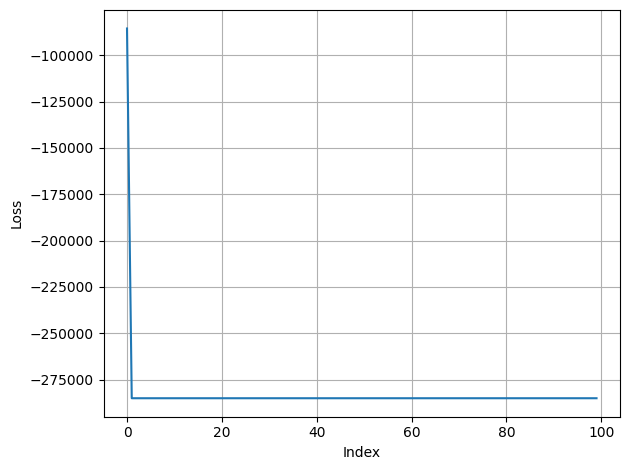

Function 'parametric_estimation' took 10.8462 seconds
parametric estimation, Predicted top 25 rankings of:
McNeese State: 253.0
James Madison: 243.0
Connecticut: 240.0
Grand Canyon: 219.0
North Carolina: 219.0
Purdue: 216.0
Houston: 213.0
Auburn: 213.0
Duke: 212.0
New Mexico: 194.0
Iowa State: 191.0
Samford: 189.0
Gonzaga: 189.0
Arizona: 181.0
Morehead State: 177.0
Illinois: 176.0
Colorado State: 175.0
Drake: 171.0
Vermont: 164.0
Florida Atlantic: 164.0
College of Charleston: 158.0
Dayton: 158.0
Saint Mary's (CA): 156.0
Nevada: 153.0
Tennessee: 153.0
parametric estimation predicted 39 of 71 games correctly


In [23]:
evaluate_model(parametric_estimation, "parametric estimation")

In [13]:
evaluate_model(higher_rank_model, "higher rank")

higher rank, Predicted top 25 rankings of:
Connecticut: -1
Houston: -2
Purdue: -3
North Carolina: -4
Tennessee: -5
Arizona: -6
Marquette: -7
Iowa State: -8
Baylor: -9
Creighton: -10
Kentucky: -11
Illinois: -12
Duke: -13
Kansas: -14
Auburn: -15
Alabama: -16
Brigham Young: -17
San Diego State: -18
Wisconsin: -19
Saint Mary's (CA): -20
Gonzaga: -21
Clemson: -22
Texas Tech: -23
South Carolina: -24
Florida: -25
higher rank predicted 46 of 71 games correctly


In [14]:
evaluate_model(bradley_terry, "bradley terry")

Function 'bradley_terry' took 5.0550 seconds
bradley terry, Predicted top 25 rankings of:
Connecticut: 2893289.699240533
Houston: 2160452.9496518956
Purdue: 2157839.9393805196
Appalachian State: 1577072.8649741171
South Carolina Upstate: 1534598.7472053329
North Carolina: 1308122.0139727823
UC Santa Barbara: 1272134.6474691806
Marquette: 1190648.6734257685
Iowa State: 1106472.55889421
Providence: 988764.5128665305
Tennessee: 971879.7178271835
Creighton: 868112.1976992118
Auburn: 815842.1499720085
Illinois: 791988.0127658918
Memphis: 722596.6268047827
Duke: 718093.0863819012
South Carolina: 708268.2906094106
UNC Wilmington: 702177.3412335734
Wake Forest: 690803.4581349202
Nevada: 660947.4060541337
Utah State: 657866.2940486564
Missouri State: 637016.0441922939
Villanova: 627036.6344126116
Baylor: 617758.9462211216
Kansas: 615384.4885881257
bradley terry predicted 46 of 71 games correctly


In [15]:
evaluate_model(pairwise_strength_eval, "pairwise strength")

NameError: name 'pairwise_strength_eval' is not defined

In [ ]:
is_tournament_game = lambda r : r["Type"] != "NCAA"
bradley_terry_weights = bradley_terry(all_games[all_games.apply(is_tournament_game, axis=1)])

In [ ]:
games_of("McNeese State", all_games)

In [ ]:
"""
clip = 10
Function 'pairwise_strength_eval' took 10.5640 seconds
pairwise strength, Predicted top 25 rankings of:
McNeese State: 1009.0
James Madison: 969.0
Connecticut: 957.0
Grand Canyon: 873.0
North Carolina: 873.0
Purdue: 861.0
Houston: 849.0
Auburn: 849.0
Duke: 845.0
New Mexico: 773.0
Iowa State: 761.0
Gonzaga: 753.0
Samford: 753.0
Arizona: 721.0
Morehead State: 705.0
Illinois: 701.0
Colorado State: 697.0
Drake: 681.0
Florida Atlantic: 653.0
Vermont: 653.0
Dayton: 629.0
College of Charleston: 629.0
Saint Mary's (CA): 621.0
Nevada: 609.0
Tennessee: 609.0
pairwise strength predicted 39 of 71 games correctly
"""

In [ ]:
"""
Skill vs. luck table.

Each point (x,y) represents the (win % in the first half of the season, win % in second half)

Regular season start: November 6, 2023
Regular season end: March 9, 2023
Regular season middle point: January 7, 2024
"""

In [ ]:
from collections import defaultdict
from matplotlib import pyplot as plt
from typing import Tuple

teams = all_teams

def team_win_pct(games, team_set):
    team_w, team_l = defaultdict(lambda: 0), defaultdict(lambda: 1)
    for _, g in games.iterrows():
        if g["For"] > g["Against"]:
            team_w[g["Team"]] += 1
            team_l[g["Opponent"]] += 1
        else:
            team_w[g["Opponent"]] += 1
            team_l[g["Team"]] += 1
    return {team: team_w[team] / (team_w[team] + team_l[team]) for team in team_set}
def team_split_win_pct(games, team_set):
    cutoff_date = pd.Timestamp('2024-01-07')
    
    after_cutoff = games[games["Date"] >= cutoff_date]
    before_cutoff = games[games["Date"] < cutoff_date]

    before_cutoff_pct = team_win_pct(before_cutoff, team_set)
    after_cutoff_pct = team_win_pct(after_cutoff, team_set)

    return {team : (before_cutoff_pct[team], after_cutoff_pct[team])
            for team in before_cutoff_pct.keys() & after_cutoff_pct.keys()}
def compute_line_endpoints(length: float, offset: Tuple[float, float], rotation: float) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    x_center, y_center = offset

    half_length = length / 2

    direction_x = half_length * np.cos(rotation)
    direction_y = half_length * np.sin(rotation)
    point1 = (x_center - direction_x, y_center - direction_y)
    point2 = (x_center + direction_x, y_center + direction_y)

    return point1, point2  
    
team_win_pcts = team_split_win_pct(all_games, ranked_teams)
data_points = np.array([v for v in team_win_pcts.values()])

x,y = zip(*team_win_pcts.values())


# Transform (x, y) to (S, T) and compute the variance along these axes
theta = np.radians(45)

rotation_matrix = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]
])
S, T = np.dot(data_points, rotation_matrix.T).T

var_S = np.var(S)  
var_T = np.var(T)  

S_line_x, S_line_y = zip(compute_line_endpoints(length=.5, offset=(.9,.2), rotation=np.pi/4))
T_line_x, T_line_y = zip(compute_line_endpoints(length=.2, offset=(.9,.9), rotation=(5*np.pi /4)))

plt.plot(S_line_x, S_line_y, label = "A = var(S)")
plt.plot(T_line_x, T_line_y, label = "B = var(T)")


# Plot the scatter plot
plt.scatter(x, y, color='blue')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("First Half Win Percent")
plt.ylabel("Second Half Win Percent")
plt.plot([0,1],[0,1], color="black")


plt.show()
var_S, var_T
R = 1 - (var_T/var_S)
R

In [ ]:
"""
For models: mean binary cross-entropy loss
"""